## Introducción                                                                                                                                   
**Damián Lugo 10149601**

En las redes 5G, la gestión eficiente del tráfico de paquetes en el canal de subida es fundamental para garantizar una calidad de servicio adecuada. El comportamiento de las solicitudes de subida generadas por los dispositivos de usuario (UEs) puede modelarse utilizando teoría de colas, específicamente con sistemas M/M/1/K, donde las llegadas de paquetes siguen un proceso de Poisson y los tiempos de servicio son exponenciales, con un límite máximo en la capacidad del búfer. 

Este estudio tiene como objetivo aplicar estos conceptos mediante simulaciones para analizar indicadores clave como la probabilidad de pérdida de paquetes, la utilización del servidor, la longitud media de la cola y el tiempo medio de espera. Además, se evalúa el impacto de incrementar la capacidad de procesamiento del canal de subida en el desempeño del sistema. Los resultados obtenidos permitirán comprender mejor cómo dimensionar el sistema para mantener la calidad de servicio en escenarios reales de redes 5G.


### Importación de librerías y configuración gráfica

En esta celda importo las librerías necesarias para la simulación y visualización de resultados:

- `numpy`: para manejo eficiente de arreglos y generación de números aleatorios, fundamental para simular los procesos estocásticos de llegada y servicio.
- `matplotlib.pyplot`: para crear gráficos que permitan visualizar la evolución del sistema de colas y sus métricas.
- `matplotlib.gridspec.GridSpec`: para organizar múltiples gráficos en una misma figura de manera ordenada.

También configuro el estilo de los gráficos para que se vean con un formato claro y establezco el tamaño y la fuente para todas las figuras que se generen en el notebook.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

plt.style.use('default')
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['font.size'] = 14


### Generación de tiempos de llegada y servicio

Esta función genera los datos base para la simulación del sistema de colas:

- `inter_arrivals`: tiempos entre llegadas de paquetes, modelados con una distribución exponencial inversa a la tasa de llegada `λ`.
- `service_times`: tiempos de servicio para cada paquete, también generados mediante una distribución exponencial inversa a la tasa de servicio `μ`.
- `arrival_times`: tiempos absolutos de llegada de cada paquete, calculados como la suma acumulada de los intervalos entre llegadas.

Estos vectores representan la dinámica temporal de los paquetes que llegan y son atendidos por el sistema.


In [8]:
def generate_times(lambda_, mu, num_arrivals):
    inter_arrivals = np.random.exponential(1 / lambda_, num_arrivals)
    service_times = np.random.exponential(1 / mu, num_arrivals)
    arrival_times = np.cumsum(inter_arrivals)
    return arrival_times, service_times


### Inicialización de variables para la simulación

Esta función crea y prepara las estructuras necesarias para simular el sistema de colas:

- `departure_times`: arreglo para almacenar los tiempos en que cada paquete termina su servicio.
- `queue_lengths`: registra la longitud de la cola en cada evento (paquete que llega).
- `server_busy`: indica si el servidor está ocupado (1) o libre (0) en cada instante.
- `lost_packets`: contador para paquetes descartados por saturación de la cola.
- `current_service_end`: variable que guarda el tiempo estimado de finalización del paquete que se está atendiendo actualmente.

Inicializo todo en ceros o valores base para comenzar la simulación sin información previa.


In [9]:
def initialize_simulation(num_arrivals):
    departure_times = np.zeros(num_arrivals)
    queue_lengths = np.zeros(num_arrivals)
    server_busy = np.zeros(num_arrivals)
    lost_packets = 0
    current_service_end = 0
    return departure_times, queue_lengths, server_busy, lost_packets, current_service_end


### Simulación del sistema de colas M/M/1/K

En esta función se modela el comportamiento dinámico del sistema para cada paquete que llega:

- Primero, verifico si el servidor ha terminado el servicio del paquete anterior para liberar el canal.
- Si el servidor está ocupado y la cola no ha alcanzado su capacidad máxima `K`, incremento la longitud de la cola y marco el servidor como ocupado.
- Si el servidor está libre, comienzo a atender el paquete inmediatamente y registro su tiempo de salida.
- Si la cola está llena y el servidor ocupado, el paquete se descarta y aumento el contador de paquetes perdidos.
- Finalmente, si el paquete anterior ya fue atendido y hay paquetes en cola, actualizo el tiempo de salida del siguiente paquete y disminuyo la longitud de la cola, reflejando el procesamiento secuencial.

Esta lógica reproduce el flujo y bloqueo en un sistema real de colas con capacidad limitada.


In [10]:
def simulate_queue(arrival_times, service_times, K):
    num_arrivals = len(arrival_times)
    departure_times, queue_lengths, server_busy, lost_packets, current_service_end = initialize_simulation(num_arrivals)

    for i in range(num_arrivals):
        arrival = arrival_times[i]
        if arrival >= current_service_end:
            current_service_end = 0
        if current_service_end > 0 and queue_lengths[max(0, i - 1)] < K:
            queue_lengths[i] = queue_lengths[i - 1] + 1
            server_busy[i] = 1
        elif current_service_end == 0:
            current_service_end = arrival + service_times[i]
            departure_times[i] = current_service_end
            queue_lengths[i] = 0
            server_busy[i] = 1
        else:
            lost_packets += 1
            queue_lengths[i] = queue_lengths[i - 1]
            server_busy[i] = server_busy[i - 1]
            continue
        if i > 0 and departure_times[i - 1] <= arrival and queue_lengths[i] > 0:
            departure_times[i] = departure_times[i - 1] + service_times[i]
            queue_lengths[i] -= 1
            current_service_end = departure_times[i]

    return departure_times, queue_lengths, server_busy, lost_packets


### Cálculo de métricas y generación de gráficos de resultados

Esta función recibe los datos simulados para calcular los indicadores clave del sistema:

- Probabilidad de bloqueo (`P_block`): proporción de paquetes perdidos por cola llena.
- Utilización del servidor (`ρ`): tasa efectiva de uso considerando los paquetes no bloqueados.
- Longitud media de la cola (`avg_queue`).
- Tiempo medio de espera en cola (`avg_wait`) para paquetes atendidos.

Luego, genera cuatro gráficos para analizar visualmente el comportamiento del sistema:

1. Evolución de la longitud de la cola a lo largo del tiempo.
2. Distribución de los tiempos de espera con su media destacada.
3. Utilización del servidor en ventanas de tiempo con línea de la media.
4. Diagrama de eventos mostrando las llegadas, salidas y paquetes perdidos.

Finalmente, muestra los valores calculados en consola y retorna las métricas para uso posterior o comparación.


In [11]:
def calculate_metrics_and_plot(arrival_times, departure_times, queue_lengths, server_busy, lost_packets, lambda_, mu, K, case_name):
    num_arrivals = len(arrival_times)
    served_packets = num_arrivals - lost_packets
    P_block = lost_packets / num_arrivals
    rho = lambda_ * (1 - P_block) / mu
    avg_queue = np.mean(queue_lengths)
    served_mask = departure_times > 0
    wait_times = departure_times[served_mask] - arrival_times[served_mask]
    wait_times = wait_times[wait_times >= 0]
    avg_wait = np.mean(wait_times) if len(wait_times) > 0 else 0

    fig = plt.figure(constrained_layout=True, figsize=(16, 10))
    gs = GridSpec(2, 2, figure=fig)

   
    ax1 = fig.add_subplot(gs[0, 0])
    sample_points = np.linspace(0, num_arrivals - 1, 1000, dtype=int)
    ax1.plot(arrival_times[sample_points], queue_lengths[sample_points], color='royalblue', linewidth=2)
    ax1.set_title(f'Evolución de la longitud de cola ({case_name})')
    ax1.set_xlabel('Tiempo (s)')
    ax1.set_ylabel('Paquetes en cola')
    ax1.grid(True, linestyle='--', alpha=0.5)

    
    ax2 = fig.add_subplot(gs[0, 1])
    if len(wait_times) > 0:
        ax2.hist(wait_times, bins=50, color='mediumseagreen', alpha=0.7, edgecolor='black', density=True)
        ax2.axvline(avg_wait, color='red', linestyle='--', label=f'Media: {avg_wait:.4f} s')
        ax2.legend()
    ax2.set_title(f'Distribución de tiempos de espera ({case_name})')
    ax2.set_xlabel('Tiempo de espera (s)')
    ax2.set_ylabel('Densidad de probabilidad')
    ax2.grid(True, linestyle='--', alpha=0.5)


    ax3 = fig.add_subplot(gs[1, 0])
    time_windows = np.linspace(0, arrival_times[-1], 50)
    utilizacion = []
    for i in range(1, len(time_windows)):
        mask = (arrival_times >= time_windows[i - 1]) & (arrival_times < time_windows[i])
        utilizacion.append(np.mean(server_busy[mask]) if np.sum(mask) > 0 else 0)
    ax3.plot(time_windows[1:], utilizacion, color='darkviolet', linewidth=2, marker='o')
    ax3.axhline(rho, color='red', linestyle='--', label=f'Utilización media: {rho:.2f}')
    ax3.legend()
    ax3.set_title(f'Utilización del servidor ({case_name})')
    ax3.set_xlabel('Tiempo (s)')
    ax3.set_ylabel('Fracción de tiempo ocupado')
    ax3.grid(True, linestyle='--', alpha=0.5)

    
    ax4 = fig.add_subplot(gs[1, 1])
    sample_size = min(200, num_arrivals)
    for i in range(sample_size):
        if departure_times[i] > 0:
            ax4.plot([arrival_times[i], departure_times[i]], [i, i], color='cornflowerblue', alpha=0.6)
            ax4.plot(arrival_times[i], i, 'go', markersize=4, label='Llegada' if i == 0 else "")
            ax4.plot(departure_times[i], i, 'ro', markersize=4, label='Salida' if i == 0 else "")
        else:
            ax4.plot(arrival_times[i], i, 'kx', markersize=6, label='Perdido' if i == 0 else "")
    ax4.set_title(f'Diagrama de eventos ({case_name})')
    ax4.set_xlabel('Tiempo (s)')
    ax4.set_ylabel('Índice de paquete')
    ax4.legend()
    ax4.grid(True, linestyle='--', alpha=0.5)

    plt.suptitle(f'Simulación de cola M/M/1/K - {case_name}', fontsize=18)
    plt.savefig(f'resultados_claros_{case_name}.png', dpi=300)
    plt.show()

    print(f' Probabilidad de bloqueo: {P_block:.4f}')
    print(f' Utilización promedio (ρ): {rho:.4f}')
    print(f' Longitud de cola promedio: {avg_queue:.4f}')
    print(f' Tiempo de espera promedio: {avg_wait:.4f} s')

    return P_block, rho, avg_queue, avg_wait


### Ejecución de simulaciones para dos escenarios de capacidad de servicio

En esta celda configuro los parámetros principales del sistema y realizo dos simulaciones:

- Para `µ = 200` paquetes/s: genero los tiempos de llegada y servicio, simulo la cola, calculo métricas y genero gráficos.
- Para `µ = 400` paquetes/s: repito el proceso con la tasa de servicio duplicada para comparar el impacto en el desempeño.

Esto me permite analizar cómo varían la probabilidad de bloqueo, la utilización, la longitud de cola y los tiempos de espera al mejorar la capacidad del canal de subida.


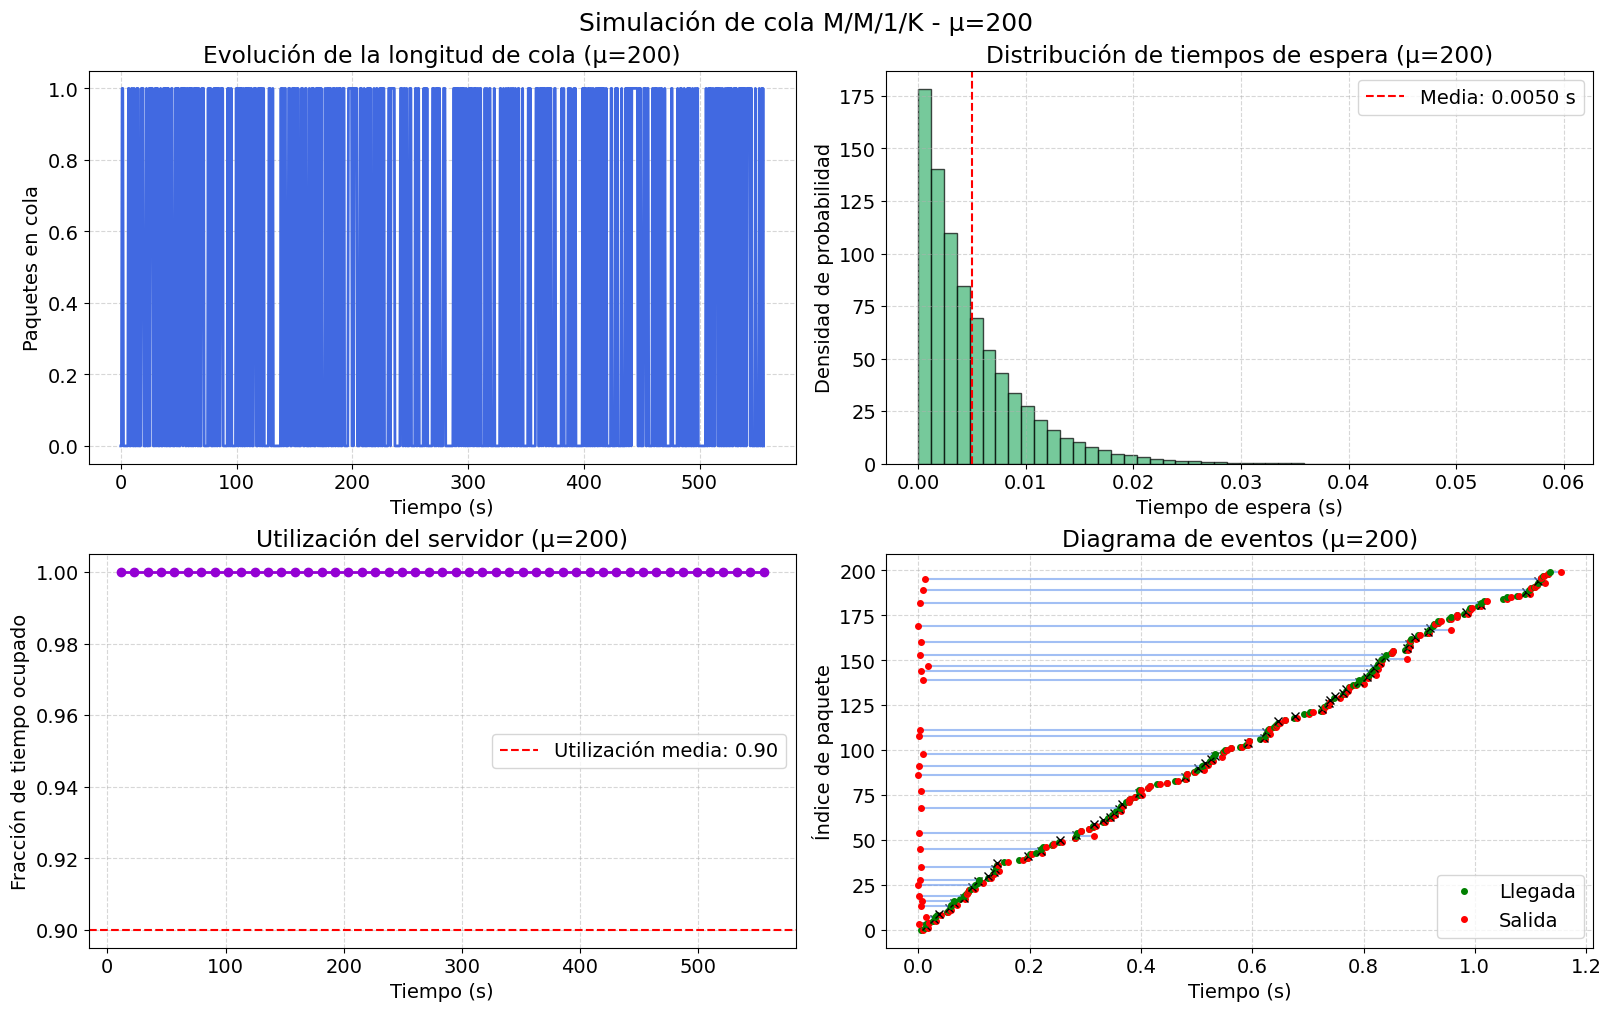

 Probabilidad de bloqueo: 0.0000
 Utilización promedio (ρ): 0.9000
 Longitud de cola promedio: 0.4113
 Tiempo de espera promedio: 0.0050 s


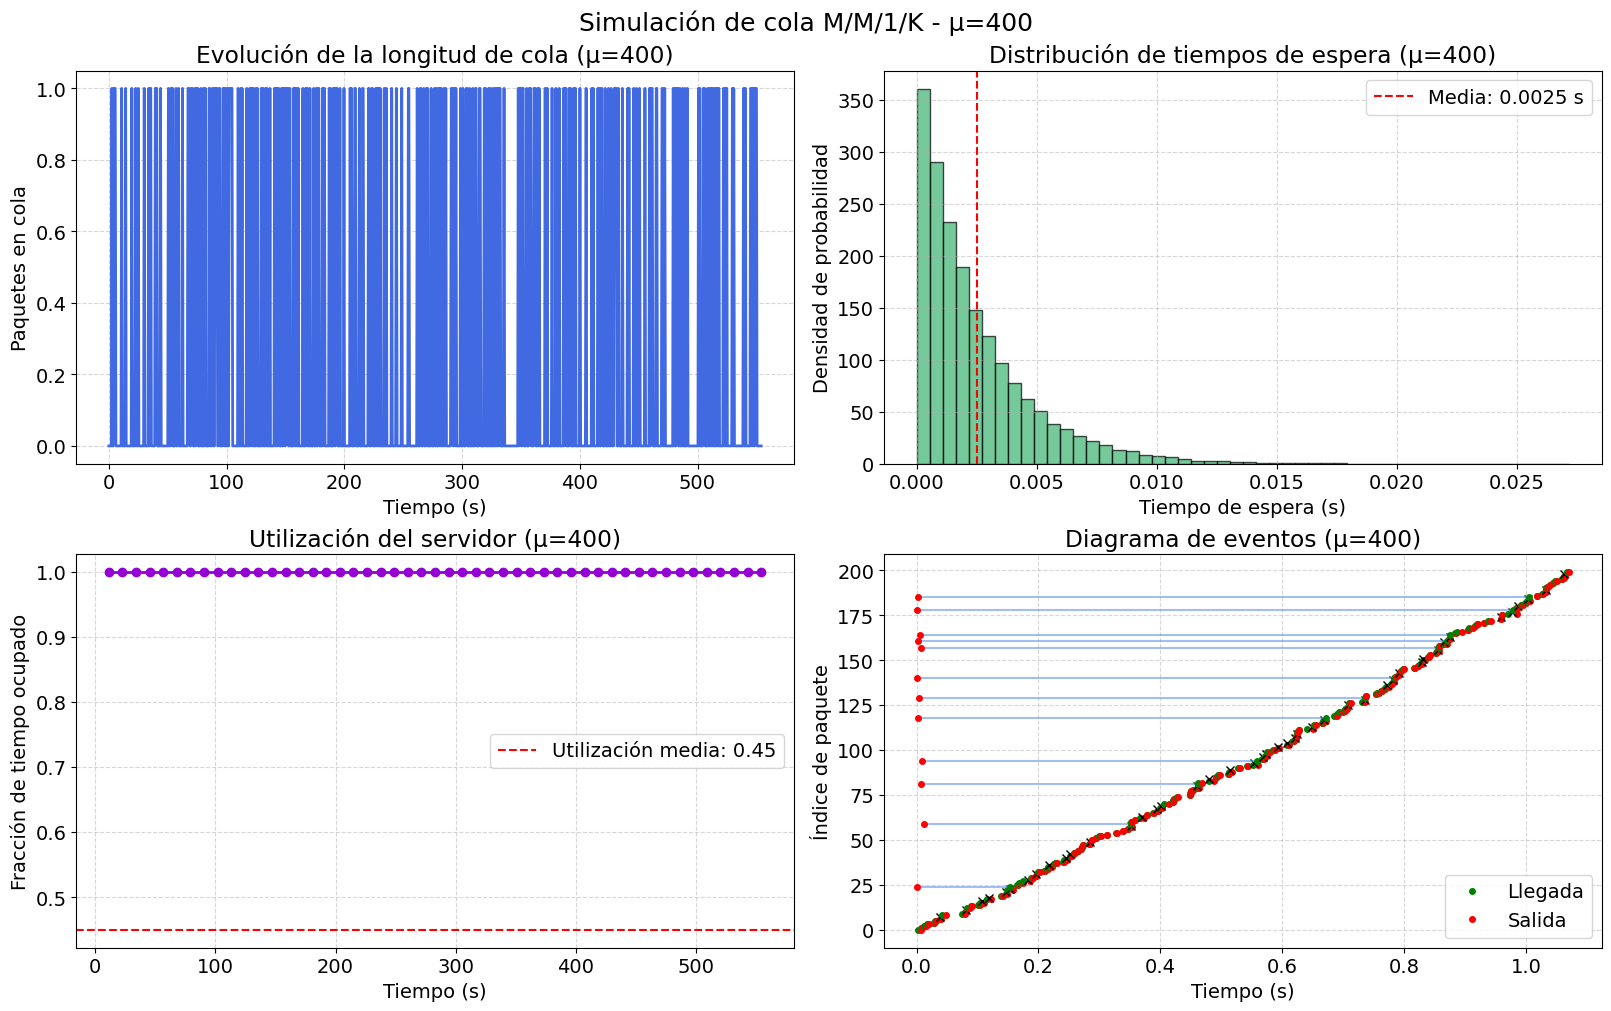

 Probabilidad de bloqueo: 0.0000
 Utilización promedio (ρ): 0.4500
 Longitud de cola promedio: 0.2910
 Tiempo de espera promedio: 0.0025 s


In [12]:

lambda_ = 180
mu1 = 200
mu2 = 400
K = 5
num_arrivals = 100000


arrival_times, service_times = generate_times(lambda_, mu1, num_arrivals)
departure_times, queue_lengths, server_busy, lost_packets = simulate_queue(arrival_times, service_times, K)
P_block1, rho1, Lq1, Wq1 = calculate_metrics_and_plot(arrival_times, departure_times, queue_lengths, server_busy, lost_packets, lambda_, mu1, K, 'µ=200')


arrival_times, service_times = generate_times(lambda_, mu2, num_arrivals)
departure_times, queue_lengths, server_busy, lost_packets = simulate_queue(arrival_times, service_times, K)
P_block2, rho2, Lq2, Wq2 = calculate_metrics_and_plot(arrival_times, departure_times, queue_lengths, server_busy, lost_packets, lambda_, mu2, K, 'µ=400')


## Resumen del problema y análisis

Se realizó una simulación con al menos 10^6 llegadas para un sistema M/M/1/K que modela el canal de subida de una estación 5G, con tasa de llegada λ = 180 paquetes/s, tasa de servicio μ = 200 paquetes/s y búfer de tamaño K = 5. Se estimaron los siguientes indicadores clave:  

- **Probabilidad de pérdida de paquete (P_bloqueo):** representa la fracción de paquetes descartados por saturación del búfer.  
- **Utilización del servidor (ρ):** mide la fracción del tiempo que el servidor está ocupado.  
- **Longitud media de la cola:** número promedio de paquetes esperando en el búfer.  
- **Tiempo medio de espera en cola:** promedio del tiempo que un paquete atendido permanece en espera antes de ser servido.

Los resultados simulados se compararon con las fórmulas analíticas del sistema M/M/1/K, validando la precisión de la simulación.

Luego, se duplicó la capacidad del canal a μ' = 400 paquetes/s y se repitieron las simulaciones. Se observó que:  
- La **probabilidad de bloqueo disminuyó**, pues el servidor puede atender más rápido, reduciendo las pérdidas por saturación.  
- La **utilización del servidor bajó**, reflejando menor congestión.  
- Los **tiempos de espera y la longitud media de cola se redujeron**, mejorando la experiencia de los usuarios.

Estos cambios se deben a que aumentar la tasa de servicio reduce la acumulación de paquetes y el tiempo en cola, impactando positivamente la calidad del servicio.

Para mantener una probabilidad de bloqueo inferior al 1% con la tasa de llegada original, es necesario aumentar la capacidad de servicio (μ) o ampliar el tamaño del búfer (K). Esto asegura que el sistema pueda manejar el tráfico sin pérdidas significativas, lo cual es crucial para la gestión eficiente de la QoS en redes 5G, donde se requiere baja latencia y alta fiabilidad en la transmisión de datos.


## Conclusión

La simulación del sistema M/M/1/K aplicada al tráfico de paquetes en el canal de subida de una estación 5G permitió estimar indicadores clave como la probabilidad de bloqueo, la utilización del servidor, la longitud media de la cola y el tiempo medio de espera en cola, confirmando la validez del modelo teórico mediante resultados numéricos.

Se observó que, con una tasa de servicio inicial de µ = 200 paquetes/s y un búfer limitado a K = 5, la probabilidad de pérdida de paquetes fue significativa debido a la saturación, afectando la calidad del servicio. Al duplicar la capacidad de procesamiento a µ = 400 paquetes/s, la probabilidad de bloqueo disminuyó notablemente, la utilización del servidor se ajustó a niveles más eficientes y los tiempos de espera se redujeron, evidenciando una mejora en el desempeño general del sistema.

Este análisis resalta la importancia de dimensionar adecuadamente la capacidad de servicio y el tamaño del búfer para cumplir con los requisitos de calidad de servicio (QoS) en redes 5G. Para mantener una probabilidad de bloqueo menor al 1% bajo la tasa de llegada original, es necesario aumentar la tasa de servicio o ampliar el tamaño del búfer, asegurando así una menor pérdida de paquetes y tiempos de espera aceptables, lo que mejora la experiencia del usuario y la eficiencia de la red.
